# MNIST variational autoencoder

* Written for the Manning Live Project - ["Semi supervised deep learning with gans for melanoma detection"](https://liveproject.manning.com/project/146/29/semi-supervised-deep-learning-with-gans-for-melanoma-detection)
* Uses a variational autoencoder to generate MNIST style digits
* Based on https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/

In [3]:
import numpy as np
import random
import torch
from torch.utils import data
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn, optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt

data_set_path = '../Datasets'
z_dims = 20
image_size = 28 * 28

def set_seeds():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(12321)

## Dataloading code

In [4]:
def data_loader(batch_size):
    transform = transforms.ToTensor()

    train_set = datasets.MNIST(data_set_path, download=False, train=True, transform=transform)
    test_set = datasets.MNIST(data_set_path, download=False, train=False, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader,  test_loader

## The model

* Model in multiple parts
* The encoder consists of a fully connected layer - then two output layers, one mu and one sigma
* The reparameterise layer takes a sample from a gaussian distribution with mean mu and standard deviation sigma
* The decode layer consists of two fully connected layers

In [5]:
def create_vae():
    class VAE(nn.Module):
        def __init__(self):
            super(VAE, self).__init__()

            # Encoder
            self.fc1 = nn.Linear(image_size, 400)
            self.fc21 = nn.Linear(400, z_dims)  # mu
            self.fc22 = nn.Linear(400, z_dims)  # log sigma^2

            # Decoder
            self.fc3 = nn.Linear(z_dims, 400)
            self.fc4 = nn.Linear(400, image_size)

        def encode(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            return self.fc21(x), self.fc22(x)

        def reparameterize(self, mu, log_var):
            if self.training:
                std = log_var.mul(0.5).exp_()
                eps = torch.randn(std.size())
                return eps.mul(std) + mu

            else:
                # In inference mode, do not add anything stochastic
                return mu

        def decode(self, x):
            x = self.fc3(x)
            x = F.relu(x)
            x = self.fc4(x)
            x = torch.sigmoid(x)
            return x

        def forward(self, x):
            mu, log_var = self.encode(x.view(-1, image_size))
            x = self.reparameterize(mu, log_var)
            x = self.decode(x)
            return x, mu, log_var
    return VAE()

## The loss function

* The Kullback - Leibler (KL) divergence between the Normal distribution generated by the model and a standard Normal distribution
* The binary cross entropy (BCE) between the output and the label (which is the input)
* These are summed together - the KL pulls the model towards a standard normal distribution and the BCE pulls the output to match the input

In [6]:
def kl_divergence(log_var, mu, batch_size):
    # Kullback – Leibler divergence is a measure of how far apart two distributions are
    # It is not technically a "distance measure" but has nice mathematical
    # properties.
    # Here we measure how far apart the distribution of Z (our vector in latent space)
    # is from a standard N(0, 1) distribution
    #
    # Note z consists of n univariate normal variables - rather than a multi-variate
    # normal

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    #  - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper

    result = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    result /= batch_size * image_size
    return result


def loss_function(output, label, mu, log_var, batch_size):
    KLD = kl_divergence(log_var, mu, batch_size)
    BCE = F.binary_cross_entropy(output, label.view(-1, image_size))

    # If the output is a probability that a classifier is true or false, then
    # BCE is a suitable error function.
    # So why use it here? Still a measure of how close the output images are
    # Pulls the output images closer to the input images
    # Whereas the KLD pulls Z to the standard Gaussian
    return KLD + BCE

## The training loop

In [7]:
def train(optimizer, model, criterion, train_loader):
    # Each iteration of the loader serves up a pair (images, labels)
    # The images are [32, 1, 28, 28] and the labels [64]
    # The batch size is 32 images and the images are 28 x 28.
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        batch_size = images.size(0)

        # Flatten images - flattened images go in and come out of the
        # network
        images = images.view(images.size(0), -1)

        # zeros all the gradients of the weights
        optimizer.zero_grad()

        output, mu, log_var = model(images)
        loss = criterion(output, images, mu, log_var, batch_size)

        # Calculates all the gradients via backpropagation
        loss.backward()

        # Adjust weights based on the gradients
        optimizer.step()

        running_loss += loss.item() * batch_size

    loss = running_loss / len(train_loader)
    print("Loss: ", loss)

## Display images

In [8]:
def gen_images(test_loader, epoch, model, sample):

    # obtain one batch of test images
    data_iter = iter(test_loader)
    images, _ = data_iter.next()
    batch_size = images.size(0)

    images_flatten = images.view(images.size(0), -1)
    # get sample outputs
    output, _, _ = model(images_flatten)

    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)

    gen_image = model.decode(sample)
    gen_image = gen_image.view(batch_size, 1, 28, 28)

    # plot the first ten input images, then reconstructed images, then generated images
    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True)

    # input images on top row, reconstructions on bottom
    for images, row, title in zip([images, output, gen_image], axes, ['Original', 'Reconstructed', 'Generated']):
        row[0].set_title('Epoch: ' + str(epoch) + ' - ' + title)
        for img, ax in zip(images, row):
            img = img.detach().numpy()
            ax.imshow(np.squeeze(img), cmap='gray')

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

## Train the model

* After every 5 epochs - writes out the input digits, the reconstructed (output) digits and generated digits
* The generated digits use the same random vector each time


Epocs:  1
Loss:  5.567041945648193

Epocs:  2
Loss:  4.619053238805135

Epocs:  3
Loss:  4.485516270828247

Epocs:  4
Loss:  4.428496653366089

Epocs:  5
Loss:  4.3894626402537025

Epocs:  6
Loss:  4.363940861384074

Epocs:  7
Loss:  4.344403188705444

Epocs:  8
Loss:  4.325701287968953

Epocs:  9
Loss:  4.313909424209594

Epocs:  10
Loss:  4.301037739944458

Epocs:  11
Loss:  4.291768939717611

Epocs:  12
Loss:  4.283515032831827

Epocs:  13
Loss:  4.275174501291911

Epocs:  14
Loss:  4.26815846303304

Epocs:  15
Loss:  4.262337781778971

Epocs:  16
Loss:  4.257241868972779

Epocs:  17
Loss:  4.250122468948364

Epocs:  18
Loss:  4.245607639948527

Epocs:  19
Loss:  4.243074484380086

Epocs:  20
Loss:  4.235987279256185


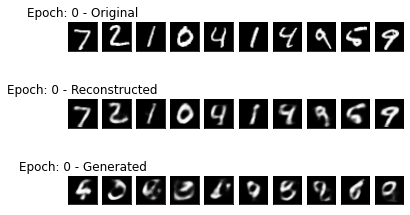

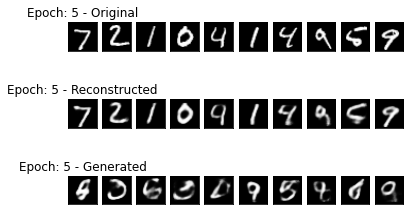

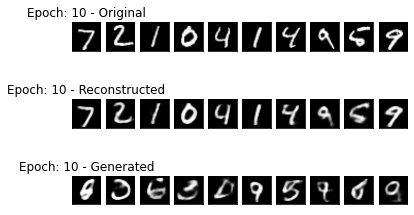

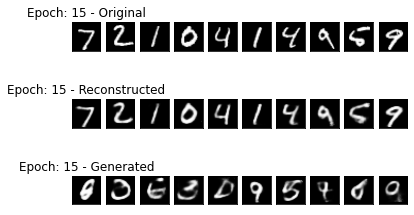

In [10]:
def main():
    set_seeds()

    batch_size = 32
    epochs = 20
    lr = 0.001
    sample = torch.randn(batch_size, z_dims)

    train_loader, test_loader = data_loader(batch_size)
    model = create_vae()
    criterion = loss_function

    optimizer = optim.Adam(model.parameters(), lr=lr)
    for e in range(epochs):
        print("\nEpocs: ", e + 1)
        train(optimizer, model, criterion, train_loader)

        if (e % 5) == 0:
            gen_images(test_loader, e, model, sample)
            
main()